# A Hierarchical model for Rugby prediction

This example now has a rich history! It is based on the [PyMC3 example from Peadar Coyle](https://docs.pymc.io/notebooks/rugby_analytics.html), which is based on [Daniel Weitzenfeld's blog post](http://danielweitzenfeld.github.io/passtheroc/blog/2014/10/28/bayes-premier-league/), which based on the work of [Baio and Blangiardo](http://discovery.ucl.ac.uk/16040/1/16040.pdf).

In this notebook, we port the model from PyMC3 to PyMC4.

We are modelling the [Six Nations Championship](https://en.wikipedia.org/wiki/Six_Nations_Championship), a rugby competition between Italy, Ireland, Scotland, England, France and Wales.

## Motivation
We wish to model a latent (unobserved) attack and defense strength for each team, and use that to make predictions about which team may win in a given year. We use results from the past five years from Wikipedia. In each of the five years of data, each team plays every other team, for a total of 60 games in the data set.

In [1]:
!date

import arviz as az
import numpy as np
import pandas as pd
import pymc4 as pm
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter
import seaborn as sns
import tensorflow as tf
from tensorflow_probability import distributions as tfd

Sun Apr 26 13:27:39 CDT 2020


In [2]:
df_all = pd.read_csv(pm.utils.get_data('rugby.csv'), index_col=0)
df_all.head()

,home_team,away_team,home_score,away_score,year
0,Wales,Italy,23,15,2014
1,France,England,26,24,2014
2,Ireland,Scotland,28,6,2014
3,Ireland,Wales,26,3,2014
4,Scotland,England,0,20,2014


In general:

* We know that the Six Nations in Rugby only has 6 teams, and they each play each other once each year.
* We have data from 5 trailing years.
* In sports, scoring is modelled with a Poisson distribution.
* Playing at home is considered a strong advantage.

## The model.

The league is made up by a total of T= 6 teams, playing each other once in a season. We indicate the number of points scored by the home and the away team in the $g$th game of the season (15 games) as $y_{g_1}$ and $y_{g_2}$ respectively. </p>
The vector of observed counts $\mathbb{y} = (y_{g_1}, y_{g_2})$ is modelled as independent Poisson:

$$
y_{g_i}| \theta_{g_j} \sim  \operatorname{Poisson}(\theta_{g_j})
$$

where the $\theta$ parameters represent the scoring intensity in the $g$th game for the team playing at home ($j=1$) and away ($j=2$), respectively.

We model these parameters according to a formulation that has been used widely in the statistical literature, assuming a log-linear random effect model:
$$
\log \theta_{g_1} = \text{home} + \text{att}_{h(g)} + \text{def}_{a(g)} 
$$

$$
\log \theta_{g_2} = \text{att}_{a(g)} + \text{def}_{h(g)}
$$


* The parameter home represents the advantage for the team hosting the game and we assume that this effect is constant for all the teams and throughout the season
* The scoring intensity is determined jointly by the attack and defense ability of the two teams involved, represented by the parameters att and def, respectively

* Conversely, for each t = 1, ..., T, the team-specific effects are modelled as exchangeable from a common distribution:

$$
\text{att}_{t} \sim \mathcal{N}(\mu_{\text{att}}, \tau_{\text{att}})\\
\text{def}_{t} \sim \mathcal{N}(\mu_{\text{def}},\tau_{\text{def}})
$$

We restrict to only the useful columns for this model.

In [3]:
teams = df_all.home_team.unique()
teams = pd.DataFrame(teams, columns=['team'])
teams['i'] = teams.index

df = (df_all.merge(teams, left_on='home_team', right_on='team', how='left')
        .rename(columns = {'i': 'home_idx'})
        .drop('team', 1)
        .merge(teams, left_on='away_team', right_on='team', how='left')
        .rename(columns = {'i': 'away_idx'})
        .drop('team', 1)
     )

observed_home_goals = df.home_score.values
observed_away_goals = df.away_score.values

home_team = df.home_idx.values
away_team = df.away_idx.values

num_teams = len(teams)
num_games = len(home_team)

att_starting_points = np.log(df.groupby('away_idx').away_score.mean())
def_starting_points = -np.log(df.groupby('home_idx').away_score.mean())

In [4]:
df.head()

,home_team,away_team,home_score,away_score,year,home_idx,away_idx
0,Wales,Italy,23,15,2014,0,4
1,France,England,26,24,2014,1,5
2,Ireland,Scotland,28,6,2014,2,3
3,Ireland,Wales,26,3,2014,2,0
4,Scotland,England,0,20,2014,3,5


## Building of the model 

We now build the model in PyMC4, specifying the global parameters, and the team-specific parameters and the likelihood function 

In [5]:
home_team = tf.constant(home_team, dtype=tf.int32)
away_team = tf.constant(away_team, dtype=tf.int32)

@pm.model
def rugby_model():

    # global model parameters
    home = yield pm.Normal('home', loc=0, scale=1)
    sd_att = yield pm.HalfStudentT('sd_att', df=3, scale=2.5)
    sd_def = yield pm.HalfStudentT('sd_def', df=3, scale=2.5)
    intercept = yield pm.Normal('intercept', loc=0, scale=1)

    # team-specific model parameters
    atts_star = yield pm.Normal("atts_star", loc=0, scale=sd_att, batch_stack=num_teams)
    defs_star = yield pm.Normal("defs_star", loc=0, scale=sd_def, batch_stack=num_teams)

    atts = yield pm.Deterministic('atts', atts_star - tf.reduce_mean(atts_star))
    defs = yield pm.Deterministic('defs', defs_star - tf.reduce_mean(defs_star))
    home_theta = yield pm.Deterministic('home_theta', tf.math.exp(intercept + home + tf.gather(atts, home_team) + tf.gather(defs, away_team)))
    away_theta = yield pm.Deterministic('away_theta', tf.math.exp(intercept + tf.gather(atts, away_team) + tf.gather(defs, home_team)))

    # likelihood of observed data
    home_points = yield pm.Poisson('home_points', rate=home_theta, observed=observed_home_goals)
    away_points = yield pm.Poisson('away_points', rate=away_theta, observed=observed_away_goals)

In [6]:
%time data = pm.sample(rugby_model(), num_chains=16)

CPU times: user 30min 21s, sys: 4min 7s, total: 34min 29s
Wall time: 15min 27s


In [7]:
data.posterior['rugby_model/atts_dim_0'] = teams.team.values
data.posterior['rugby_model/defs_dim_0'] = teams.team.values
data.posterior['rugby_model/atts_star_dim_0'] = teams.team.values

Note that with `PyMC4`, it is easy to use more chains for inference. Here we ran with 16 chains, which makes the traceplot even more difficult to read than normal! So, we will combine the traces when displaying them.

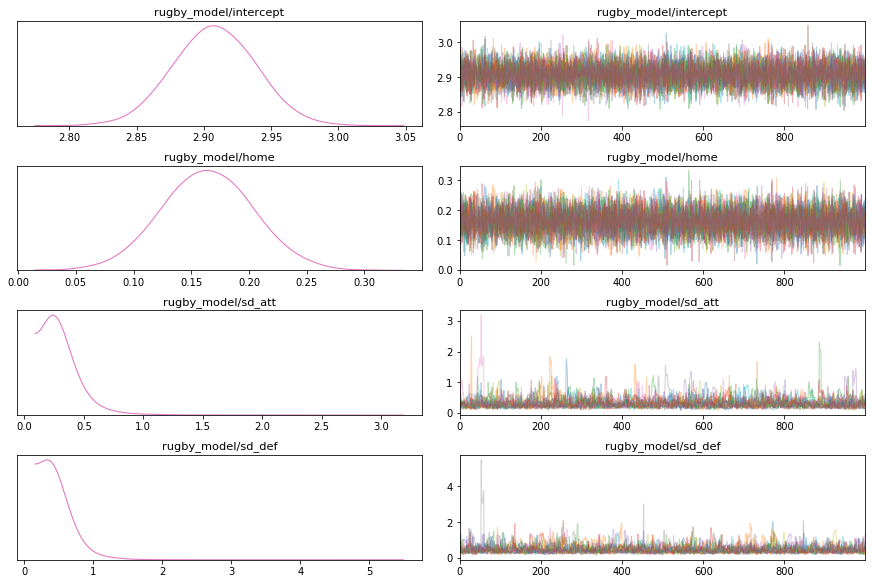

In [8]:
az.plot_trace(data, var_names=['rugby_model/intercept', 'rugby_model/home', 'rugby_model/sd_att', 'rugby_model/sd_def'], combined=True);

In [9]:
bfmi = az.bfmi(data)
max_gr = max(np.max(gr_stats) for gr_stats in az.rhat(data).values())

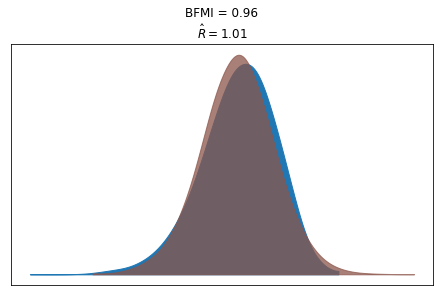

In [10]:
ax = az.plot_energy(data, legend=False, figsize=(6, 4))
ax.set_title(f"BFMI = {np.mean(bfmi):.2f}\n" + "$\hat{R}=$" + f"{max_gr.values:.2f}");

Let us look at some of the stats, just to verify that our model has returned the correct attributes. We can see that some teams are stronger than others. This is what we would expect with attack.

First is the 94th percentile confidence intervals for different team's attack strengths (note that these have no unit!)

In [11]:
az.stats.hpd(data.posterior['rugby_model/atts']).mean(axis=1)

array([[ 0.09594344,  0.24827945],
       [-0.16881236, -0.0008248 ],
       [ 0.02973597,  0.18399043],
       [-0.20534103, -0.03141476],
       [-0.439154  , -0.23558265],
       [ 0.18137005,  0.33442107]], dtype=float32)

We can easily find the median values, using the `median` method.

In [22]:
data.posterior['rugby_model/atts'].median(axis=[0,1])

<xarray.DataArray 'rugby_model/atts' (rugby_model/atts_dim_0: 6)>
array([ 0.17237836, -0.08479229,  0.10842006, -0.1159686 , -0.33553863,
        0.25720757], dtype=float32)
Coordinates:
  * rugby_model/atts_dim_0  (rugby_model/atts_dim_0) object 'Wales' ... 'England'

## Results

Now we can inspect the latent parameters for offense and defense that the model has predicted. For quick intuition, Italy has done quite poorly over the past 5 years, and Ireland has been one of the stronger teams.

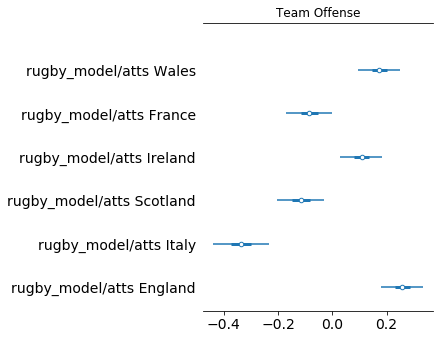

In [14]:
ax = az.plot_forest(data, var_names=['rugby_model/atts'], combined=True)
ax[0].set_title('Team Offense');

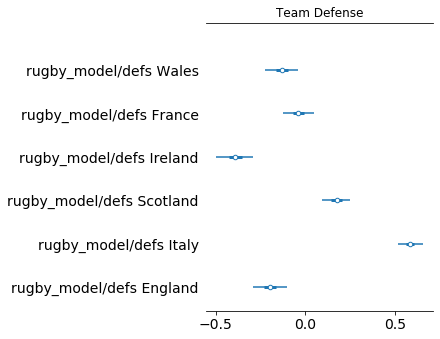

In [15]:
ax = az.plot_forest(data, var_names=['rugby_model/defs'], combined=True)
ax[0].set_title('Team Defense');

Good teams like Ireland and England have a strong negative effect defense. Which is what we expect. We expect our strong teams to have strong positive effects in attack and strong negative effects in defense. 

This approach that we're using of inspecting the posterior distributions of our parameters is part of a good statistical workflow. Having done this, it is possible that our priors could be better specified. However this is beyond the scope of this article. We recommend for a good discussion of 'statistical workflow' you visit [Robust Statistical Workflow with RStan](http://mc-stan.org/users/documentation/case-studies/rstan_workflow.html)

Let's continue plotting output, starting with the range for our defensive effects. 

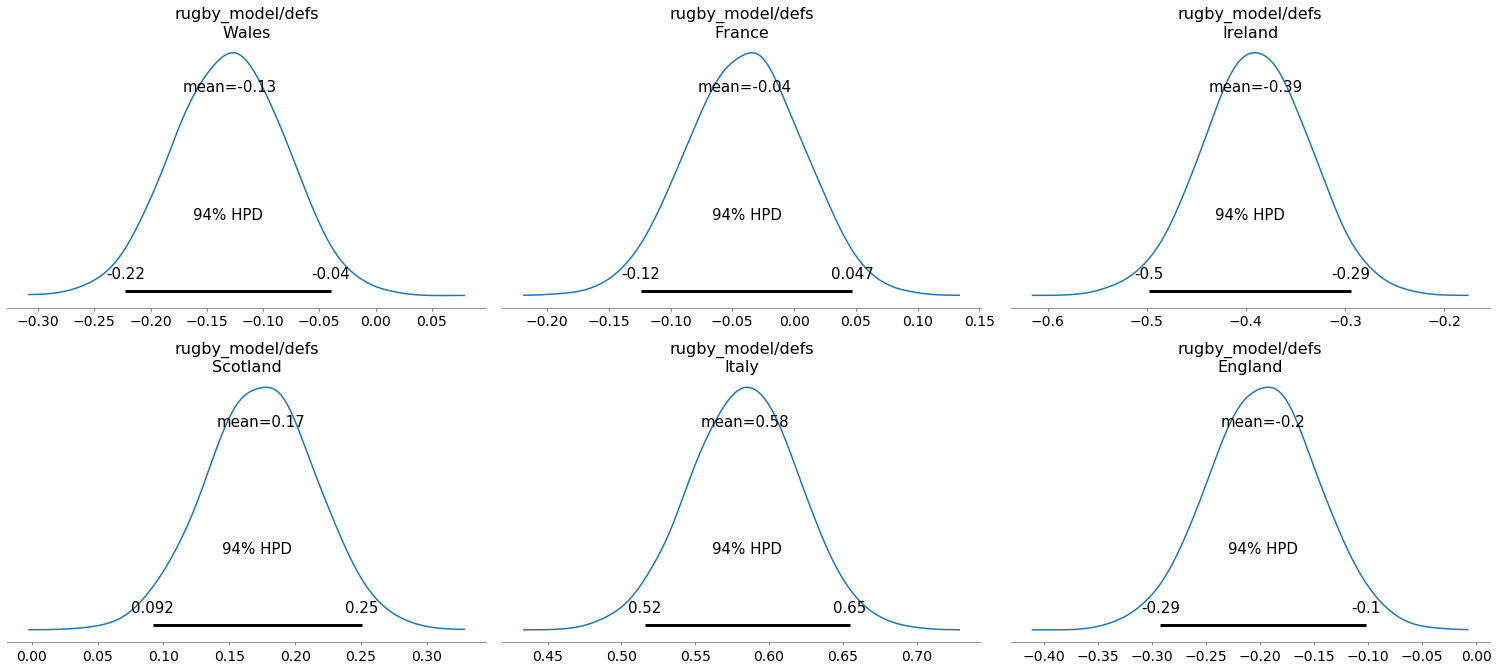

In [16]:
axes = az.plot_posterior(data, var_names=['rugby_model/defs'])

We conclude by simulating 1,000 future seasons for each of our chains.

## Simulating from our model

Since it appears that we have a model that behaves reasonably well, based on what we know about this tournament, let's use it to simulate tournaments and estimate the probability that each of the teams would win.

In [17]:
pp_trace = pm.sample_posterior_predictive(model=rugby_model(), trace=data).posterior_predictive

In [18]:
home_sim_df = pd.DataFrame.from_dict({
    'sim_points_{}'.format(i): 3 * home_won
    for i, home_won in enumerate((pp_trace['rugby_model/home_points'] > pp_trace['rugby_model/away_points']).values.reshape(-1, df.shape[0]))
})
home_sim_df.insert(0, 'team', df['home_team'])

away_sim_df = pd.DataFrame.from_dict({
    'sim_points_{}'.format(i): 3 * away_won
    for i, away_won in enumerate((pp_trace['rugby_model/home_points'] < pp_trace['rugby_model/away_points']).values.reshape(-1, df.shape[0]))
})
away_sim_df.insert(0, 'team', df['away_team'])

In [19]:
sim_table = (home_sim_df.groupby('team')
                        .sum()
                        .add(away_sim_df.groupby('team')
                                        .sum())
                        .rank(ascending=False, method='min', axis=0)
                        .reset_index()
                        .melt(id_vars='team', value_name='rank')
                        .groupby('team')['rank']
                        .value_counts()
                        .unstack(level='rank')
                        .fillna(0)
                        .div(pp_trace.dims['chain'] * pp_trace.dims['draw']))
sim_table

rank,1.0,2.0,3.0,4.0,5.0,6.0
team,,,,,,
England,35.282750,17.451500,6.663500,0.558937,0.040375,0.002938
France,4.401313,5.173250,9.007812,35.563750,5.569063,0.284813
Ireland,30.405938,19.237687,9.331188,0.946500,0.075250,0.003438
Italy,2.875250,0.114187,0.056500,0.437500,2.444375,54.072187
Scotland,3.667625,3.054875,3.464500,11.149437,37.759437,0.904125
Wales,17.459937,18.715625,21.005125,2.633125,0.176563,0.009625


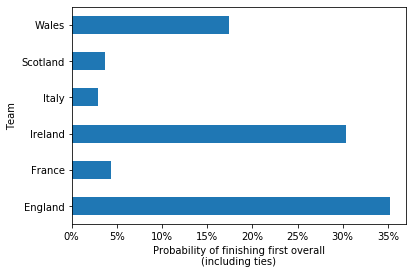

In [20]:
ax = sim_table.loc[:, 1.0].plot(kind='barh')

ax.xaxis.set_major_formatter(PercentFormatter(decimals=0));
ax.set_xlabel("Probability of finishing first overall\n(including ties)")

ax.set_ylabel("Team");

We see according to this model that Ireland finishes with the most points about 60% of the time, and England finishes with the most points 45% of the time and Wales finishes with the most points about 10% of the time.  (Note that these probabilities do not sum to 100% since there is a non-zero chance of a tie atop the table.)